In [150]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error,f1_score
from collections import Counter
from sklearn.linear_model import Ridge, Lasso
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, r2_score


In [ ]:

# Cargamos el modelo y los codificadores entrenados
data = pd.read_csv('static/datasets/2024.1_encuesta-sysarmy.csv')

# Seleccion de columnas relevantes y preprocesamiento
relevant_columns = [
    'trabajo_de',
    'dedicacion',
    'seniority',
    'anos_de_experiencia',
    'me_identifico_genero',
    'plataformas_que_utilizas_en_tu_puesto_actual',
    'lenguajes_de_programacion_o_tecnologias_que_utilices_en_tu_puesto_actual',
    'frameworksherramientas_y_librerias_que_utilices_en_tu_puesto_actual',
    'bases_de_datos',
    'qa_testing',
    'ultimo_salario_mensual_o_retiro_bruto_en_tu_moneda_local'
]

filtered_data = data[relevant_columns].dropna()

columns_rename = {
    "ultimo_salario_mensual_o_retiro_bruto_en_tu_moneda_local" : "salario_bruto",
    "me_identifico_genero" : "genero",
    "anos_de_experiencia" : "experiencia",
    "plataformas_que_utilizas_en_tu_puesto_actual" : "plataformas",
    "lenguajes_de_programacion_o_tecnologias_que_utilices_en_tu_puesto_actual" : "lenguajes",
    "frameworksherramientas_y_librerias_que_utilices_en_tu_puesto_actual" : "frameworks",
    "bases_de_datos":"databases"
}

filtered_data.rename(columns=columns_rename, inplace=True)

filtered_data

In [ ]:
# Definir los límites de los rangos (de 100,000 en 100,000)
rango_bins = list(range(0, 1750000 + 100000, 25000))

# Contar la cantidad de salarios en cada rango, asegurándote de incluir todos los rangos
conteo_rangos = pd.cut(filtered_data['salario_bruto'], bins=rango_bins, include_lowest=True).value_counts()

# Reindexar para incluir todos los rangos definidos, incluso los que tienen un conteo de 0
conteo_rangos = conteo_rangos.reindex(pd.IntervalIndex.from_breaks(rango_bins), fill_value=0).sort_index()

pd.set_option('display.max_rows', None)  # Mostrar todas las filas
# Mostrar los resultados
print(conteo_rangos)
#pd.set_option('display.max_rows', 20)  # Mostrar todas las filas

In [ ]:
# Filtrar y eliminar las filas donde 'salario_bruto' sea mayor a 75000 o menor a 550000
MIN_SAL = 775000
MAX_SAL = 1800000
filtered_data = filtered_data[(filtered_data['salario_bruto'] > MIN_SAL) & (filtered_data['salario_bruto'] < MAX_SAL)]
filtered_data

In [ ]:
# Dropear filas donde las columnas especificadas sean nulas
filtered_data = filtered_data.dropna(subset=['plataformas','frameworks','databases','qa_testing'])
filtered_data

In [155]:
# Normalizar categorias genero
print(filtered_data['genero'].value_counts())

genero
Hombre Cis           1696
Mujer Cis             493
No binarie             12
Prefiero no decir      11
Trans                   2
🦄                       1
Lesbiana                1
Gay                     1
Name: count, dtype: int64


In [156]:
# Dada la disparidad de registros, llevo a "otros" aquellos registros con pocos registros
# Lista de categorías válidas
generos = ['Hombre Cis', 'Mujer Cis']

# Reemplazar valores no válidos por "Otros"
filtered_data['genero'] = filtered_data['genero'].apply(lambda x: 'Otro' if x not in generos else x)
filtered_data['genero'] = filtered_data['genero'].replace({
    "Hombre Cis": "Hombre",
    "Mujer Cis": "Mujer",
    "Otro": "Otro"
})
print(filtered_data['genero'].value_counts())

genero
Hombre    1696
Mujer      493
Otro        28
Name: count, dtype: int64


In [157]:
# Normalizar categorias experiencia
filtered_data['experiencia'] = pd.to_numeric(filtered_data['experiencia'], errors='coerce')

# Función para categorizar
def categorizar_experiencia(anos):
    if 1 <= anos <= 4:
        return "1_a_4"
    elif 5 <= anos <= 9:
        return "5_a_9"
    else:
        return "10_mas"

# Aplicar la función y crear la nueva columna
filtered_data['rango_experiencia'] = filtered_data['experiencia'].apply(categorizar_experiencia)

print(filtered_data['rango_experiencia'].value_counts())

rango_experiencia
1_a_4     1180
10_mas     585
5_a_9      452
Name: count, dtype: int64


In [158]:
# Normalizar trabajo_de
# Obtener los 20 roles más comunes
top = filtered_data['trabajo_de'].value_counts().head(10).index.tolist()
# Filtrar el DataFrame para quedarnos solo con los registros de los 20 roles
filtered_data = filtered_data[filtered_data['trabajo_de'].isin(top)]
filtered_data.head()

trabajo_de dedicacion    seniority  experiencia  genero  \
0         Developer  Full-Time  Semi-Senior            3  Hombre   
2     Data Engineer  Full-Time  Semi-Senior            5  Hombre   
3         Developer  Full-Time       Senior            9  Hombre   
6  Technical Leader  Full-Time       Senior            9  Hombre   
7  Technical Leader  Full-Time  Semi-Senior            3  Hombre   

                                      plataformas  \
0                     Amazon Web Services, Docker   
2                   Azure, Docker, Windows Server   
3    Amazon Web Services, Azure, Docker, Firebase   
6  Amazon Web Services, Docker, Kubernetes, Linux   
7    Amazon Web Services, Docker, Firebase, Linux   

                                           lenguajes  \
0                  HTML, Javascript, PHP, TypeScript   
2                          C#, Python, R, Scala, SQL   
3             CSS, HTML, Javascript, SQL, TypeScript   
6  CSS, HTML, Javascript, PHP, Python, SQL, TypeS...   
7     CSS, HTML, Javascript, Python, SQL, TypeScript   

                                          frameworks  \
0    Laravel, Next.js, React.js, WordPress, Tailwind   
2                          Ninguno de los anteriores   
3  Angular, Bootstrap, Cordova, Flutter, jQuery, ...   
6                                  Next.js, React.js   
7          Django, Flask, Next.js, Node.js, React.js   

                                           databases  \
0                                            MariaDB   
2  Microsoft Azure (Tables, CosmosDB, SQL, etc), ...   
3                 MongoDB, MySQL, PostgreSQL, SQLite   
6                  Amazon RDS/Aurora, MongoDB, MySQL   
7                          Ninguna de las anteriores   

                                          qa_testing  salario_bruto  \
0                                               Jest      1700000.0   
2                                            Postman      1000000.0   
3  Jest, JUnit, Karma, Postman, Visual Studio Cod...       850000.0   
6                                             Pytest       835469.0   
7                       Cypress, Postman, Playwright      1050000.0   

  rango_experiencia  
0             1_a_4  
2             5_a_9  
3             5_a_9  
6             5_a_9  
7             1_a_4

In [159]:
# Normalizar salario_bruto
filtered_data['salario_bruto'] = pd.to_numeric(filtered_data['salario_bruto'], errors='coerce')

filtered_data.head()

/var/folders/dj/9jcx42f14w50c4qqsswdw8cr0000gn/T/ipykernel_2084/1833504145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['salario_bruto'] = pd.to_numeric(filtered_data['salario_bruto'], errors='coerce')


trabajo_de dedicacion    seniority  experiencia  genero  \
0         Developer  Full-Time  Semi-Senior            3  Hombre   
2     Data Engineer  Full-Time  Semi-Senior            5  Hombre   
3         Developer  Full-Time       Senior            9  Hombre   
6  Technical Leader  Full-Time       Senior            9  Hombre   
7  Technical Leader  Full-Time  Semi-Senior            3  Hombre   

                                      plataformas  \
0                     Amazon Web Services, Docker   
2                   Azure, Docker, Windows Server   
3    Amazon Web Services, Azure, Docker, Firebase   
6  Amazon Web Services, Docker, Kubernetes, Linux   
7    Amazon Web Services, Docker, Firebase, Linux   

                                           lenguajes  \
0                  HTML, Javascript, PHP, TypeScript   
2                          C#, Python, R, Scala, SQL   
3             CSS, HTML, Javascript, SQL, TypeScript   
6  CSS, HTML, Javascript, PHP, Python, SQL, TypeS...   
7     CSS, HTML, Javascript, Python, SQL, TypeScript   

                                          frameworks  \
0    Laravel, Next.js, React.js, WordPress, Tailwind   
2                          Ninguno de los anteriores   
3  Angular, Bootstrap, Cordova, Flutter, jQuery, ...   
6                                  Next.js, React.js   
7          Django, Flask, Next.js, Node.js, React.js   

                                           databases  \
0                                            MariaDB   
2  Microsoft Azure (Tables, CosmosDB, SQL, etc), ...   
3                 MongoDB, MySQL, PostgreSQL, SQLite   
6                  Amazon RDS/Aurora, MongoDB, MySQL   
7                          Ninguna de las anteriores   

                                          qa_testing  salario_bruto  \
0                                               Jest      1700000.0   
2                                            Postman      1000000.0   
3  Jest, JUnit, Karma, Postman, Visual Studio Cod...       850000.0   
6                                             Pytest       835469.0   
7                       Cypress, Postman, Playwright      1050000.0   

  rango_experiencia  
0             1_a_4  
2             5_a_9  
3             5_a_9  
6             5_a_9  
7             1_a_4

In [160]:
# Normalizar categorias skills : plataformas
all_platform = filtered_data['plataformas'].str.split(',').explode().str.strip()
all_platform = all_platform[~all_platform.isin(['','Ninguna de las anteriores'])]
# 2. Contar la frecuencia de cada lenguaje
platform_counts = all_platform.value_counts()
most_common_platform = Counter(all_platform).most_common(10)
print(most_common_platform)

[('Linux', 715), ('Docker', 640), ('Amazon Web Services', 448), ('Windows Server', 414), ('Azure', 402), ('Google Cloud Platform', 254), ('Kubernetes', 232), ('VMWare', 212), ('Firebase', 116), ('SAP', 91)]


In [161]:
#Vamos a crear tres columnas nuevas.
#Una para indicar si el candidato conoce un plataformas de sistemas operativos 
#Una para indicar si el candidato conoce un plataformas de contenedores 
#Una para indicar si el candidato conoce un plataformas de cloud
#[('Linux', 827), ('Docker', 696), ('Amazon Web Services', 512), ('Windows Server', 510), ('Azure', 479), ('Google Cloud Platform', 310), ('VMWare', 275), ('Kubernetes', 253), ('SAP', 120), ('Firebase', 118)]

# Listas de términos para sistemas operativos, contenedores y cloud
sisop_terms = ['linux', 'windows server']
container_terms = ['docker', 'kubernetes']
cloud_terms = ['amazon web services', 'azure', 'google cloud platform', 'firebase']
virtualization_terms = ['vmware']

# Crear las nuevas columnas
filtered_data['plataformas_sisop'] = filtered_data['plataformas'].apply(
    lambda x: 1 if any(term in str(x).lower() for term in sisop_terms) else 0
)

filtered_data['plataformas_container'] = filtered_data['plataformas'].apply(
    lambda x: 1 if any(term in str(x).lower() for term in container_terms) else 0
)

filtered_data['plataformas_cloud'] = filtered_data['plataformas'].apply(
    lambda x: 1 if any(term in str(x).lower() for term in cloud_terms) else 0
)

filtered_data['plataformas_virtualization'] = filtered_data['plataformas'].apply(
    lambda x: 1 if any(term in str(x).lower() for term in virtualization_terms) else 0
)

filtered_data[['trabajo_de','plataformas','plataformas_sisop','plataformas_container','plataformas_cloud','plataformas_virtualization']]

/var/folders/dj/9jcx42f14w50c4qqsswdw8cr0000gn/T/ipykernel_2084/3288627235.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['plataformas_sisop'] = filtered_data['plataformas'].apply(
/var/folders/dj/9jcx42f14w50c4qqsswdw8cr0000gn/T/ipykernel_2084/3288627235.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['plataformas_container'] = filtered_data['plataformas'].apply(
/var/folders/dj/9jcx42f14w50c4qqsswdw8cr0000gn/T/ipykernel_2084/3288627235.py:22: SettingWithCopyWarning: 

trabajo_de  \
0                     Developer   
2                 Data Engineer   
3                     Developer   
6              Technical Leader   
7              Technical Leader   
8                     Developer   
19                Data Engineer   
21                  UX Designer   
26                    Developer   
27                    Developer   
29                    Developer   
31                    Developer   
33                    Developer   
35             Technical Leader   
36                    Developer   
38                    Developer   
39                    Developer   
41                    Developer   
43                    Developer   
48                    Developer   
49                    Developer   
51                    Developer   
54                  QA / Tester   
58                    Developer   
60      SysAdmin / DevOps / SRE   
69                     HelpDesk   
70                    Developer   
76             Technical Leader   
77      SysAdmin / DevOps / SRE   
79             Technical Leader   
83             Technical Leader   
85      SysAdmin / DevOps / SRE   
87                    Developer   
89             Technical Leader   
90      SysAdmin / DevOps / SRE   
92                    Developer   
101     SysAdmin / DevOps / SRE   
102                 QA / Tester   
107   BI Analyst / Data Analyst   
108                   Developer   
112                   Developer   
114                   Developer   
115                   Developer   
118                   Developer   
120   BI Analyst / Data Analyst   
121                   Developer   
122            Technical Leader   
125   BI Analyst / Data Analyst   
133            Technical Leader   
136                   Developer   
147               Data Engineer   
163                   Developer   
165                   Developer   
169            Business Analyst   
190                   Developer   
194                   Developer   
202                   Developer   
203                   Developer   
204                   Developer   
206            Technical Leader   
224                   Developer   
225                   Developer   
238                    HelpDesk   
239                   Developer   
244                   Developer   
257                   Developer   
259                   Developer   
269            Technical Leader   
270                   Developer   
276          Manager / Director   
278                   Developer   
282            Business Analyst   
284     SysAdmin / DevOps / SRE   
286          Manager / Director   
289                   Developer   
294   BI Analyst / Data Analyst   
298               Data Engineer   
313                   Developer   
317   BI Analyst / Data Analyst   
320                   Developer   
332                   Developer   
333                   Developer   
337                   Developer   
340                 QA / Tester   
341          Manager / Director   
342                   Developer   
348                   Developer   
349                   Developer   
350                   Developer   
352                   Developer   
353     SysAdmin / DevOps / SRE   
359                   Developer   
362   BI Analyst / Data Analyst   
367   BI Analyst / Data Analyst   
380                   Developer   
384                   Developer   
385                   Developer   
386                   Developer   
392                   Developer   
394                   Developer   
397            Technical Leader   
398                   Developer   
402                   Developer   
409                   Developer   
411   BI Analyst / Data Analyst   
412                   Developer   
413          Manager / Director   
414                 QA / Tester   
418                   Developer   
420          Manager / Director   
422                   Developer   
423                   Developer   
425                   Developer   
429                 UX Designer

In [162]:
# Normalizar categorias skills : lenguajes
all_terms = filtered_data['lenguajes'].str.split(',').explode().str.strip()
all_terms = all_terms[~all_terms.isin(['', 'Ninguna de las anteriores', 'Ninguno de los anteriores'])]
# 2. Contar la frecuencia de cada lenguaje
terms_count = all_terms.value_counts()
most_common_term = Counter(all_terms).most_common(13)
print(most_common_term)

[('SQL', 894), ('Javascript', 777), ('HTML', 591), ('Python', 480), ('CSS', 410), ('TypeScript', 400), ('Java', 313), ('Bash/Shell', 276), ('PHP', 266), ('.NET', 234), ('C#', 191), ('VBA', 52), ('Go', 49)]


In [163]:
# [('SQL', 998), ('Javascript', 813), ('HTML', 633), ('Python', 578), ('CSS', 432), ('TypeScript', 405), ('Java', 338), ('Bash/Shell', 319), ('PHP', 288), ('.NET', 251), ('C#', 200), ('VBA', 58), ('Go', 52)]

# Listas de términos para lenguajes web, software y sistemas
dev_front_terms = ['javascript', 'typescript', 'html', 'css']
dev_back_terms = ['sql','python', '.net', 'c#', 'go', 'java', 'php']
dev_desktop_terms = ['.net', 'vba', 'c#']
dev_scripting_terms = ['bash/shell']

# Crear las nuevas columnas
filtered_data['lenguajes_dev_web_front'] = filtered_data['lenguajes'].apply(
    lambda x: 1 if any(term in str(x).lower() for term in dev_front_terms) else 0
)

filtered_data['lenguajes_dev_web_back'] = filtered_data['lenguajes'].apply(
    lambda x: 1 if (
        any(term in str(x).lower() for term in dev_back_terms) or
        ('java' in str(x).lower() and (str(x).strip().lower() == 'java' or str(x).lower().endswith('java,')))
    ) else 0
)

filtered_data['lenguajes_dev_desktop_app'] = filtered_data['lenguajes'].apply(
    lambda x: 1 if any(term in str(x).lower() for term in dev_desktop_terms) else 0
)

filtered_data['lenguajes_dev_scripting'] = filtered_data['lenguajes'].apply(
    lambda x: 1 if any(term in str(x).lower() for term in dev_scripting_terms) else 0
)

filtered_data[['trabajo_de','lenguajes', 'lenguajes_dev_web_front', 'lenguajes_dev_web_back', 'lenguajes_dev_desktop_app','lenguajes_dev_scripting']]

/var/folders/dj/9jcx42f14w50c4qqsswdw8cr0000gn/T/ipykernel_2084/2077995733.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['lenguajes_dev_web_front'] = filtered_data['lenguajes'].apply(
/var/folders/dj/9jcx42f14w50c4qqsswdw8cr0000gn/T/ipykernel_2084/2077995733.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['lenguajes_dev_web_back'] = filtered_data['lenguajes'].apply(
/var/folders/dj/9jcx42f14w50c4qqsswdw8cr0000gn/T/ipykernel_2084/2077995733.py:21: SettingWithCopyWarnin

trabajo_de  \
0                     Developer   
2                 Data Engineer   
3                     Developer   
6              Technical Leader   
7              Technical Leader   
8                     Developer   
19                Data Engineer   
21                  UX Designer   
26                    Developer   
27                    Developer   
29                    Developer   
31                    Developer   
33                    Developer   
35             Technical Leader   
36                    Developer   
38                    Developer   
39                    Developer   
41                    Developer   
43                    Developer   
48                    Developer   
49                    Developer   
51                    Developer   
54                  QA / Tester   
58                    Developer   
60      SysAdmin / DevOps / SRE   
69                     HelpDesk   
70                    Developer   
76             Technical Leader   
77      SysAdmin / DevOps / SRE   
79             Technical Leader   
83             Technical Leader   
85      SysAdmin / DevOps / SRE   
87                    Developer   
89             Technical Leader   
90      SysAdmin / DevOps / SRE   
92                    Developer   
101     SysAdmin / DevOps / SRE   
102                 QA / Tester   
107   BI Analyst / Data Analyst   
108                   Developer   
112                   Developer   
114                   Developer   
115                   Developer   
118                   Developer   
120   BI Analyst / Data Analyst   
121                   Developer   
122            Technical Leader   
125   BI Analyst / Data Analyst   
133            Technical Leader   
136                   Developer   
147               Data Engineer   
163                   Developer   
165                   Developer   
169            Business Analyst   
190                   Developer   
194                   Developer   
202                   Developer   
203                   Developer   
204                   Developer   
206            Technical Leader   
224                   Developer   
225                   Developer   
238                    HelpDesk   
239                   Developer   
244                   Developer   
257                   Developer   
259                   Developer   
269            Technical Leader   
270                   Developer   
276          Manager / Director   
278                   Developer   
282            Business Analyst   
284     SysAdmin / DevOps / SRE   
286          Manager / Director   
289                   Developer   
294   BI Analyst / Data Analyst   
298               Data Engineer   
313                   Developer   
317   BI Analyst / Data Analyst   
320                   Developer   
332                   Developer   
333                   Developer   
337                   Developer   
340                 QA / Tester   
341          Manager / Director   
342                   Developer   
348                   Developer   
349                   Developer   
350                   Developer   
352                   Developer   
353     SysAdmin / DevOps / SRE   
359                   Developer   
362   BI Analyst / Data Analyst   
367   BI Analyst / Data Analyst   
380                   Developer   
384                   Developer   
385                   Developer   
386                   Developer   
392                   Developer   
394                   Developer   
397            Technical Leader   
398                   Developer   
402                   Developer   
409                   Developer   
411   BI Analyst / Data Analyst   
412                   Developer   
413          Manager / Director   
414                 QA / Tester   
418                   Developer   
420          Manager / Director   
422                   Developer   
423                   Developer   
425                   Developer   
429                 UX Designer

In [164]:
# Normalizar categorias skills : frameworks
all_terms = filtered_data['frameworks'].str.split(',').explode().str.strip()
all_terms = all_terms[~all_terms.isin(['', 'Ninguna de las anteriores', 'Ninguno de los anteriores'])]
# 2. Contar la frecuencia de cada lenguaje
terms_count = all_terms.value_counts()
most_common_term = Counter(all_terms).most_common(14)
print(most_common_term)

[('Node.js', 393), ('React.js', 370), ('Bootstrap', 284), ('.NET Core', 214), ('Angular', 211), ('jQuery', 209), ('Next.js', 158), ('Spring', 145), ('WordPress', 132), ('Laravel', 93), ('Vue.js', 90), ('Django', 82), ('Hibernate', 80), ('Flask', 64)]


In [165]:
#[('Node.js', 417), ('React.js', 380), ('Bootstrap', 301), ('.NET Core', 227), ('Angular', 223), ('jQuery', 219), ('Next.js', 160), ('Spring', 154), ('WordPress', 150), ('Laravel', 103), ('Vue.js', 96), ('Django', 90), ('Hibernate', 85), ('Flask', 73)]

# Listas de términos para el front-end y back-end
front_terms = ['react.js', 'bootstrap', 'jquery', 'angular', 'next.js','vue.js']
back_terms = ['node.js', '.net core', 'spring', 'hibernate','laravel','django','hibernate','flask']
webmaster_terms = ['wordpress']

# Crear las nuevas columnas
filtered_data['framework_front'] = filtered_data['frameworks'].apply(
    lambda x: 1 if any(term in str(x).lower() for term in front_terms) else 0
)

filtered_data['framework_back'] = filtered_data['frameworks'].apply(
    lambda x: 1 if any(term in str(x).lower() for term in back_terms) else 0
)

filtered_data['framework_webmaster'] = filtered_data['frameworks'].apply(
    lambda x: 1 if any(term in str(x).lower() for term in webmaster_terms) else 0
)

filtered_data[['trabajo_de','frameworks', 'framework_front', 'framework_back', 'framework_webmaster']]

/var/folders/dj/9jcx42f14w50c4qqsswdw8cr0000gn/T/ipykernel_2084/632850018.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['framework_front'] = filtered_data['frameworks'].apply(
/var/folders/dj/9jcx42f14w50c4qqsswdw8cr0000gn/T/ipykernel_2084/632850018.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['framework_back'] = filtered_data['frameworks'].apply(
/var/folders/dj/9jcx42f14w50c4qqsswdw8cr0000gn/T/ipykernel_2084/632850018.py:17: SettingWithCopyWarning: 
A value is try

trabajo_de  \
0                     Developer   
2                 Data Engineer   
3                     Developer   
6              Technical Leader   
7              Technical Leader   
8                     Developer   
19                Data Engineer   
21                  UX Designer   
26                    Developer   
27                    Developer   
29                    Developer   
31                    Developer   
33                    Developer   
35             Technical Leader   
36                    Developer   
38                    Developer   
39                    Developer   
41                    Developer   
43                    Developer   
48                    Developer   
49                    Developer   
51                    Developer   
54                  QA / Tester   
58                    Developer   
60      SysAdmin / DevOps / SRE   
69                     HelpDesk   
70                    Developer   
76             Technical Leader   
77      SysAdmin / DevOps / SRE   
79             Technical Leader   
83             Technical Leader   
85      SysAdmin / DevOps / SRE   
87                    Developer   
89             Technical Leader   
90      SysAdmin / DevOps / SRE   
92                    Developer   
101     SysAdmin / DevOps / SRE   
102                 QA / Tester   
107   BI Analyst / Data Analyst   
108                   Developer   
112                   Developer   
114                   Developer   
115                   Developer   
118                   Developer   
120   BI Analyst / Data Analyst   
121                   Developer   
122            Technical Leader   
125   BI Analyst / Data Analyst   
133            Technical Leader   
136                   Developer   
147               Data Engineer   
163                   Developer   
165                   Developer   
169            Business Analyst   
190                   Developer   
194                   Developer   
202                   Developer   
203                   Developer   
204                   Developer   
206            Technical Leader   
224                   Developer   
225                   Developer   
238                    HelpDesk   
239                   Developer   
244                   Developer   
257                   Developer   
259                   Developer   
269            Technical Leader   
270                   Developer   
276          Manager / Director   
278                   Developer   
282            Business Analyst   
284     SysAdmin / DevOps / SRE   
286          Manager / Director   
289                   Developer   
294   BI Analyst / Data Analyst   
298               Data Engineer   
313                   Developer   
317   BI Analyst / Data Analyst   
320                   Developer   
332                   Developer   
333                   Developer   
337                   Developer   
340                 QA / Tester   
341          Manager / Director   
342                   Developer   
348                   Developer   
349                   Developer   
350                   Developer   
352                   Developer   
353     SysAdmin / DevOps / SRE   
359                   Developer   
362   BI Analyst / Data Analyst   
367   BI Analyst / Data Analyst   
380                   Developer   
384                   Developer   
385                   Developer   
386                   Developer   
392                   Developer   
394                   Developer   
397            Technical Leader   
398                   Developer   
402                   Developer   
409                   Developer   
411   BI Analyst / Data Analyst   
412                   Developer   
413          Manager / Director   
414                 QA / Tester   
418                   Developer   
420          Manager / Director   
422                   Developer   
423                   Developer   
425                   Developer   
429                 UX Designer

In [166]:
# Normalizar categorias skills : databases
all_terms = filtered_data['databases'].str.split(',').explode().str.strip()
all_terms = all_terms[~all_terms.isin(['','etc)','Google Cloud Storage', 'Ninguna de las anteriores', 'Ninguno de los anteriores'])]
# 2. Contar la frecuencia de cada lenguaje
terms_count = all_terms.value_counts()
most_common_term = Counter(all_terms).most_common(15)
print(most_common_term)

[('MySQL', 613), ('Microsoft SQL Server', 544), ('PostgreSQL', 418), ('MongoDB', 273), ('MariaDB', 229), ('Oracle', 211), ('SQLite', 133), ('Microsoft Azure (Tables', 126), ('CosmosDB', 126), ('SQL', 126), ('Redis', 122), ('ElasticSearch', 91), ('Amazon DynamoDB', 90), ('Amazon RDS/Aurora', 82), ('Amazon Redshift', 35)]


In [167]:
# ('MySQL', 685), ('Microsoft SQL Server', 619), ('PostgreSQL', 461), ('MongoDB', 290), ('MariaDB', 256), ('Oracle', 240), ('Microsoft Azure (Tables', 148), ('CosmosDB', 148), ('SQL', 148), ('SQLite', 144), ('Redis', 130), ('ElasticSearch', 101)
# Definir los términos para bases de datos SQL y NoSQL
sql_terms = ['mysql', 'microsoft sql server', 'postgresql', 'oracle', 'mariadb','sqlite','sql']
nosql_terms = ['mongodb', 'microsoft azure (tables', 'cosmosdb', 'elasticsearch', 'redis']

# Crear las columnas db_sql y db_nosql
filtered_data['databases_sql'] = filtered_data['databases'].apply(
    lambda x: 1 if any(term in str(x).lower() for term in sql_terms) else 0
)

filtered_data['databases_nosql'] = filtered_data['databases'].apply(
    lambda x: 1 if any(term in str(x).lower() for term in nosql_terms) else 0
)

filtered_data[['trabajo_de','databases', 'databases_sql', 'databases_nosql']]

/var/folders/dj/9jcx42f14w50c4qqsswdw8cr0000gn/T/ipykernel_2084/2376098924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['databases_sql'] = filtered_data['databases'].apply(
/var/folders/dj/9jcx42f14w50c4qqsswdw8cr0000gn/T/ipykernel_2084/2376098924.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['databases_nosql'] = filtered_data['databases'].apply(


trabajo_de  \
0                     Developer   
2                 Data Engineer   
3                     Developer   
6              Technical Leader   
7              Technical Leader   
8                     Developer   
19                Data Engineer   
21                  UX Designer   
26                    Developer   
27                    Developer   
29                    Developer   
31                    Developer   
33                    Developer   
35             Technical Leader   
36                    Developer   
38                    Developer   
39                    Developer   
41                    Developer   
43                    Developer   
48                    Developer   
49                    Developer   
51                    Developer   
54                  QA / Tester   
58                    Developer   
60      SysAdmin / DevOps / SRE   
69                     HelpDesk   
70                    Developer   
76             Technical Leader   
77      SysAdmin / DevOps / SRE   
79             Technical Leader   
83             Technical Leader   
85      SysAdmin / DevOps / SRE   
87                    Developer   
89             Technical Leader   
90      SysAdmin / DevOps / SRE   
92                    Developer   
101     SysAdmin / DevOps / SRE   
102                 QA / Tester   
107   BI Analyst / Data Analyst   
108                   Developer   
112                   Developer   
114                   Developer   
115                   Developer   
118                   Developer   
120   BI Analyst / Data Analyst   
121                   Developer   
122            Technical Leader   
125   BI Analyst / Data Analyst   
133            Technical Leader   
136                   Developer   
147               Data Engineer   
163                   Developer   
165                   Developer   
169            Business Analyst   
190                   Developer   
194                   Developer   
202                   Developer   
203                   Developer   
204                   Developer   
206            Technical Leader   
224                   Developer   
225                   Developer   
238                    HelpDesk   
239                   Developer   
244                   Developer   
257                   Developer   
259                   Developer   
269            Technical Leader   
270                   Developer   
276          Manager / Director   
278                   Developer   
282            Business Analyst   
284     SysAdmin / DevOps / SRE   
286          Manager / Director   
289                   Developer   
294   BI Analyst / Data Analyst   
298               Data Engineer   
313                   Developer   
317   BI Analyst / Data Analyst   
320                   Developer   
332                   Developer   
333                   Developer   
337                   Developer   
340                 QA / Tester   
341          Manager / Director   
342                   Developer   
348                   Developer   
349                   Developer   
350                   Developer   
352                   Developer   
353     SysAdmin / DevOps / SRE   
359                   Developer   
362   BI Analyst / Data Analyst   
367   BI Analyst / Data Analyst   
380                   Developer   
384                   Developer   
385                   Developer   
386                   Developer   
392                   Developer   
394                   Developer   
397            Technical Leader   
398                   Developer   
402                   Developer   
409                   Developer   
411   BI Analyst / Data Analyst   
412                   Developer   
413          Manager / Director   
414                 QA / Tester   
418                   Developer   
420          Manager / Director   
422                   Developer   
423                   Developer   
425                   Developer   
429                 UX Designer

In [168]:
# Normalizar categorias skills : qa_testing
all_terms = filtered_data['qa_testing'].str.split(',').explode().str.strip()
all_terms = all_terms[~all_terms.isin(['','Ninguna de las anteriores', 'Ninguno de los anteriores'])]
# 2. Contar la frecuencia de cada lenguaje
terms_count = all_terms.value_counts()
most_common_term = Counter(all_terms).most_common(10)
print(most_common_term)

[('Postman', 407), ('Jest', 157), ('JUnit', 154), ('Selenium', 95), ('Cypress', 89), ('SoapUI', 76), ('PHPUnit', 58), ('Visual Studio Coded UI', 51), ('Cucumber', 47), ('Xunit', 28)]


In [169]:
# [('Postman', 435), ('Jest', 159), ('JUnit', 159), ('Selenium', 104), ('Cypress', 91), ('SoapUI', 81), ('Visual Studio Coded UI', 58), ('PHPUnit', 58), ('Cucumber', 47), ('Xunit', 28)]

# Definir los términos para las pruebas de QA
api_terms = ['postman','soapui']
unit_terms = ['junit', 'phpunit', 'jest', 'cucumber','xunit']
auto_terms = ['selenium', 'cypress', 'visual studio coded ui']

# Crear las columnas qa_api, qa_unit y qa_auto
filtered_data['qa_testing_api'] = filtered_data['qa_testing'].apply(
    lambda x: 1 if any(term in str(x).lower() for term in api_terms) else 0
)

filtered_data['qa_testing_unit'] = filtered_data['qa_testing'].apply(
    lambda x: 1 if any(term in str(x).lower() for term in unit_terms) else 0
)

filtered_data['qa_testing_auto'] = filtered_data['qa_testing'].apply(
    lambda x: 1 if any(term in str(x).lower() for term in auto_terms) else 0
)

filtered_data[['trabajo_de','qa_testing','qa_testing_api','qa_testing_unit','qa_testing_auto']]

/var/folders/dj/9jcx42f14w50c4qqsswdw8cr0000gn/T/ipykernel_2084/188021775.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['qa_testing_api'] = filtered_data['qa_testing'].apply(
/var/folders/dj/9jcx42f14w50c4qqsswdw8cr0000gn/T/ipykernel_2084/188021775.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['qa_testing_unit'] = filtered_data['qa_testing'].apply(
/var/folders/dj/9jcx42f14w50c4qqsswdw8cr0000gn/T/ipykernel_2084/188021775.py:17: SettingWithCopyWarning: 
A value is try

trabajo_de  \
0                     Developer   
2                 Data Engineer   
3                     Developer   
6              Technical Leader   
7              Technical Leader   
8                     Developer   
19                Data Engineer   
21                  UX Designer   
26                    Developer   
27                    Developer   
29                    Developer   
31                    Developer   
33                    Developer   
35             Technical Leader   
36                    Developer   
38                    Developer   
39                    Developer   
41                    Developer   
43                    Developer   
48                    Developer   
49                    Developer   
51                    Developer   
54                  QA / Tester   
58                    Developer   
60      SysAdmin / DevOps / SRE   
69                     HelpDesk   
70                    Developer   
76             Technical Leader   
77      SysAdmin / DevOps / SRE   
79             Technical Leader   
83             Technical Leader   
85      SysAdmin / DevOps / SRE   
87                    Developer   
89             Technical Leader   
90      SysAdmin / DevOps / SRE   
92                    Developer   
101     SysAdmin / DevOps / SRE   
102                 QA / Tester   
107   BI Analyst / Data Analyst   
108                   Developer   
112                   Developer   
114                   Developer   
115                   Developer   
118                   Developer   
120   BI Analyst / Data Analyst   
121                   Developer   
122            Technical Leader   
125   BI Analyst / Data Analyst   
133            Technical Leader   
136                   Developer   
147               Data Engineer   
163                   Developer   
165                   Developer   
169            Business Analyst   
190                   Developer   
194                   Developer   
202                   Developer   
203                   Developer   
204                   Developer   
206            Technical Leader   
224                   Developer   
225                   Developer   
238                    HelpDesk   
239                   Developer   
244                   Developer   
257                   Developer   
259                   Developer   
269            Technical Leader   
270                   Developer   
276          Manager / Director   
278                   Developer   
282            Business Analyst   
284     SysAdmin / DevOps / SRE   
286          Manager / Director   
289                   Developer   
294   BI Analyst / Data Analyst   
298               Data Engineer   
313                   Developer   
317   BI Analyst / Data Analyst   
320                   Developer   
332                   Developer   
333                   Developer   
337                   Developer   
340                 QA / Tester   
341          Manager / Director   
342                   Developer   
348                   Developer   
349                   Developer   
350                   Developer   
352                   Developer   
353     SysAdmin / DevOps / SRE   
359                   Developer   
362   BI Analyst / Data Analyst   
367   BI Analyst / Data Analyst   
380                   Developer   
384                   Developer   
385                   Developer   
386                   Developer   
392                   Developer   
394                   Developer   
397            Technical Leader   
398                   Developer   
402                   Developer   
409                   Developer   
411   BI Analyst / Data Analyst   
412                   Developer   
413          Manager / Director   
414                 QA / Tester   
418                   Developer   
420          Manager / Director   
422                   Developer   
423                   Developer   
425                   Developer   
429                 UX Designer

In [170]:
filtered_data.head()

trabajo_de dedicacion    seniority  experiencia  genero  \
0         Developer  Full-Time  Semi-Senior            3  Hombre   
2     Data Engineer  Full-Time  Semi-Senior            5  Hombre   
3         Developer  Full-Time       Senior            9  Hombre   
6  Technical Leader  Full-Time       Senior            9  Hombre   
7  Technical Leader  Full-Time  Semi-Senior            3  Hombre   

                                      plataformas  \
0                     Amazon Web Services, Docker   
2                   Azure, Docker, Windows Server   
3    Amazon Web Services, Azure, Docker, Firebase   
6  Amazon Web Services, Docker, Kubernetes, Linux   
7    Amazon Web Services, Docker, Firebase, Linux   

                                           lenguajes  \
0                  HTML, Javascript, PHP, TypeScript   
2                          C#, Python, R, Scala, SQL   
3             CSS, HTML, Javascript, SQL, TypeScript   
6  CSS, HTML, Javascript, PHP, Python, SQL, TypeS...   
7     CSS, HTML, Javascript, Python, SQL, TypeScript   

                                          frameworks  \
0    Laravel, Next.js, React.js, WordPress, Tailwind   
2                          Ninguno de los anteriores   
3  Angular, Bootstrap, Cordova, Flutter, jQuery, ...   
6                                  Next.js, React.js   
7          Django, Flask, Next.js, Node.js, React.js   

                                           databases  \
0                                            MariaDB   
2  Microsoft Azure (Tables, CosmosDB, SQL, etc), ...   
3                 MongoDB, MySQL, PostgreSQL, SQLite   
6                  Amazon RDS/Aurora, MongoDB, MySQL   
7                          Ninguna de las anteriores   

                                          qa_testing  ...  \
0                                               Jest  ...   
2                                            Postman  ...   
3  Jest, JUnit, Karma, Postman, Visual Studio Cod...  ...   
6                                             Pytest  ...   
7                       Cypress, Postman, Playwright  ...   

   lenguajes_dev_desktop_app lenguajes_dev_scripting  framework_front  \
0                          0                       0                1   
2                          1                       0                0   
3                          0                       0                1   
6                          0                       0                1   
7                          0                       0                1   

   framework_back  framework_webmaster  databases_sql  databases_nosql  \
0               1                    1              1                0   
2               0                    0              1                1   
3               1                    0              1                1   
6               0                    0              1                1   
7               1                    0              0                0   

   qa_testing_api  qa_testing_unit  qa_testing_auto  
0               0                1                0  
2               1                0                0  
3               1                1                1  
6               0                0                0  
7               1                0                1  

[5 rows x 28 columns]

In [171]:
df_modificado = filtered_data.copy()

label_encoders = {
    'trabajo_de': LabelEncoder(),
    #'modalidad_de_trabajo' : LabelEncoder(),
    'dedicacion': LabelEncoder(),
    'seniority': LabelEncoder(),
    'rango_experiencia': LabelEncoder(),
    'genero': LabelEncoder(),
}

for column, encoder in label_encoders.items():
    df_modificado[column] = encoder.fit_transform(filtered_data[column])

columns_categoricas = ['experiencia','plataformas','lenguajes','frameworks','databases','qa_testing']

df_modificado.drop(columns=columns_categoricas, inplace=True)

df_modificado.head()

trabajo_de  dedicacion  seniority  genero  salario_bruto  \
0           3           0          1       0      1700000.0   
2           2           0          1       0      1000000.0   
3           3           0          2       0       850000.0   
6           8           0          2       0       835469.0   
7           8           0          1       0      1050000.0   

   rango_experiencia  plataformas_sisop  plataformas_container  \
0                  1                  0                      1   
2                  2                  1                      1   
3                  2                  0                      1   
6                  2                  1                      1   
7                  1                  1                      1   

   plataformas_cloud  plataformas_virtualization  ...  \
0                  1                           0  ...   
2                  1                           0  ...   
3                  1                           0  ...   
6                  1                           0  ...   
7                  1                           0  ...   

   lenguajes_dev_desktop_app  lenguajes_dev_scripting  framework_front  \
0                          0                        0                1   
2                          1                        0                0   
3                          0                        0                1   
6                          0                        0                1   
7                          0                        0                1   

   framework_back  framework_webmaster  databases_sql  databases_nosql  \
0               1                    1              1                0   
2               0                    0              1                1   
3               1                    0              1                1   
6               0                    0              1                1   
7               1                    0              0                0   

   qa_testing_api  qa_testing_unit  qa_testing_auto  
0               0                1                0  
2               1                0                0  
3               1                1                1  
6               0                0                0  
7               1                0                1  

[5 rows x 22 columns]

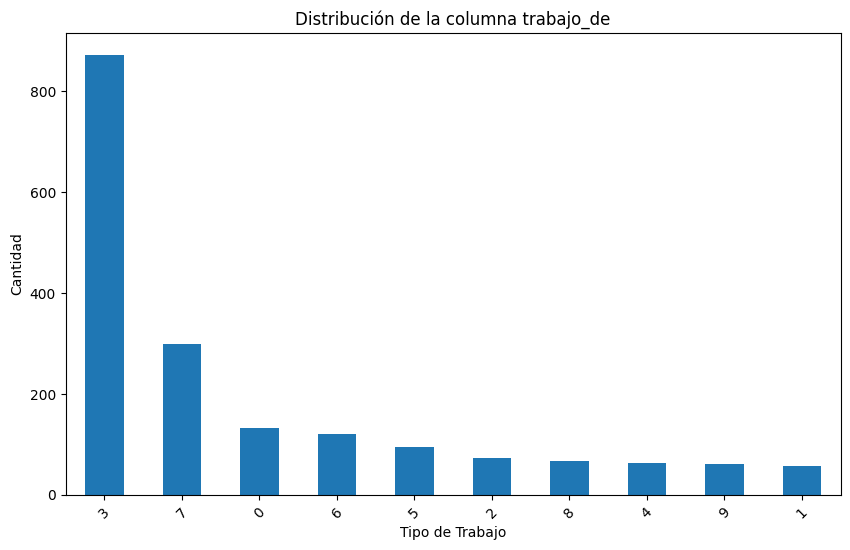

In [172]:
# Obtener el conteo de cada valor en la columna 'trabajo_de'
distribucion_trabajo = df_modificado['trabajo_de'].value_counts()

# Crear un gráfico de barras
distribucion_trabajo.plot(kind='bar', figsize=(10,6))

# Añadir etiquetas y título
plt.title('Distribución de la columna trabajo_de')
plt.xlabel('Tipo de Trabajo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

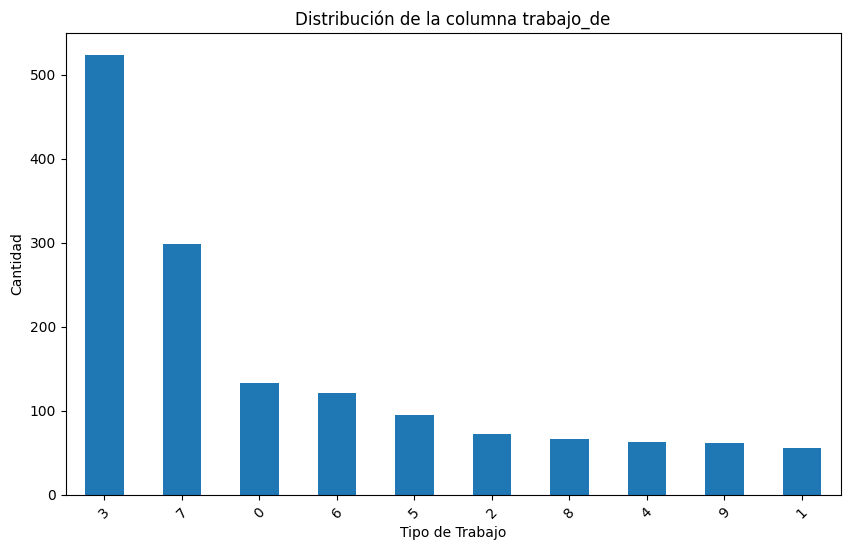

In [173]:
TARGET = 3
# Calcular el número de filas a eliminar para trabajo_de = TARGET
num_filas_a_eliminar = int(len(df_modificado[df_modificado['trabajo_de'] == TARGET]) * 0.4)

# Eliminar filas aleatorias para trabajo_de = TARGET
filas_a_eliminar = df_modificado[df_modificado['trabajo_de'] == TARGET].sample(n=num_filas_a_eliminar, random_state=1)
df_modificado = df_modificado.drop(filas_a_eliminar.index)

# Obtener el conteo de cada valor en la columna 'trabajo_de'
distribucion_trabajo = df_modificado['trabajo_de'].value_counts()

# Crear un gráfico de barras
distribucion_trabajo.plot(kind='bar', figsize=(10,6))

# Añadir etiquetas y título
plt.title('Distribución de la columna trabajo_de')
plt.xlabel('Tipo de Trabajo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

# Creamos y entrenamos un modelo de Regresión Lineal para predecir los salarios.

In [174]:
X = df_modificado.drop(columns=['salario_bruto'])  # Variables predictoras
y = df_modificado['salario_bruto']  # Variable objetivo

In [175]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [176]:
# Crear y ajustar el modelo de regresión lineal para salario_bruto
modelo = LinearRegression()
modelo.fit(X_train, y_train)

LinearRegression()

In [177]:
# Predecir y evaluar el modelo para salario_bruto
y_pred = modelo.predict(X_test)
mse_bruto = mean_squared_error(y_test, y_pred)
r2_bruto = r2_score(y_test, y_pred)

# Mostrar resultados para salario_bruto
print(f'R^2 para salario_bruto: {r2_bruto}')
print(f'MSE para salario_bruto: {mse_bruto}')

R^2 para salario_bruto: 0.050038607660219725
MSE para salario_bruto: 73372931427.63629


# Aplicamos nuestro modelo de la misma forma en que se haría con un candidato

In [178]:
filtered_data['trabajo_de'].unique()

array(['Developer', 'Data Engineer', 'Technical Leader', 'UX Designer',
       'QA / Tester', 'SysAdmin / DevOps / SRE', 'HelpDesk',
       'BI Analyst / Data Analyst', 'Business Analyst',
       'Manager / Director'], dtype=object)

In [179]:
df_user = pd.DataFrame([{
    "trabajo_de": label_encoders['trabajo_de'].transform(["Developer"])[0],
    "dedicacion": label_encoders['dedicacion'].transform(["Full-Time"])[0],
    "seniority": label_encoders['seniority'].transform(["Senior"])[0],
    "genero": label_encoders['genero'].transform(["Mujer"])[0],
    "rango_experiencia": label_encoders['rango_experiencia'].transform(["10_mas"])[0],
    'plataformas_sisop' : 1,
    'plataformas_container' : 0,
    'plataformas_cloud' : 0, 
    'plataformas_virtualization' : 1,
    'lenguajes_dev_web_front' : 1, 
    'lenguajes_dev_web_back' : 1,
    'lenguajes_dev_desktop_app' : 0, 
    'lenguajes_dev_scripting' : 1,
    'framework_front' : 0, 
    'framework_back' : 1, 
    'framework_webmaster' : 0,
    'databases_sql' : 1, 
    'databases_nosql' : 1, 
    'qa_testing_api' : 1,
    'qa_testing_unit' : 0,
    'qa_testing_auto' : 0
}])

df_user

trabajo_de  dedicacion  seniority  genero  rango_experiencia  \
0           3           0          2       1                  0   

   plataformas_sisop  plataformas_container  plataformas_cloud  \
0                  1                      0                  0   

   plataformas_virtualization  lenguajes_dev_web_front  ...  \
0                           1                        1  ...   

   lenguajes_dev_desktop_app  lenguajes_dev_scripting  framework_front  \
0                          0                        1                0   

   framework_back  framework_webmaster  databases_sql  databases_nosql  \
0               1                    0              1                1   

   qa_testing_api  qa_testing_unit  qa_testing_auto  
0               1                0                0  

[1 rows x 21 columns]

In [180]:
prediccion = modelo.predict(df_user)
resultado = f"El salario bruto predicho es: ${prediccion[0]:.2f}"
print(resultado)

El salario bruto predicho es: $1259817.86


In [183]:
import pandas as pd

technologies = pd.DataFrame(['linux','docker','postman'])

df = pd.DataFrame()

df['plataformas_sisop'] = technologies.apply(
    lambda x: 1 if any(term in str(x).lower() for term in sisop_terms) else 0
)

df['plataformas_container'] = technologies.apply(
    lambda x: 1 if any(term in str(x).lower() for term in container_terms) else 0
)

df['plataformas_cloud'] = technologies.apply(
    lambda x: 1 if any(term in str(x).lower() for term in cloud_terms) else 0
)

df['plataformas_virtualization'] = technologies.apply(
    lambda x: 1 if any(term in str(x).lower() for term in virtualization_terms) else 0
)

df

plataformas_sisop  plataformas_container  plataformas_cloud  \
0                  1                      1                  0   

   plataformas_virtualization  
0                           0